#Case Understanding & objective
This notebook contains methodology applied to evaluate Regression based Supervised Machine learning models in form of accuracy, interpreteablility & explainability. To address data driven decision when applied to real business dataset of S&P 500 of the largest publicly traded companies in the United States.

Main business question driving analysis: How the components of income statement, cash flow statements & balance sheet affect the labelled variable net income ?

In [1]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import shap
shap.initjs()

In [2]:
#LOAD DATA
file_path = '/content/financial data sp500 companies.csv'
financial_KPIs = pd.read_csv(file_path)

In [3]:
#to check variable properties
financial_KPIs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Data columns (total 19 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              2012 non-null   int64  
 1   date                                    2012 non-null   object 
 2   firm                                    2012 non-null   object 
 3   Ticker                                  2012 non-null   object 
 4   Research Development                    634 non-null    float64
 5   Income Before Tax                       2011 non-null   float64
 6   Net Income                              2012 non-null   float64
 7   Selling General Administrative          1952 non-null   float64
 8   Gross Profit                            2012 non-null   float64
 9   Ebit                                    2012 non-null   float64
 10  Operating Income                        2011 non-null   floa

Date ,firm & ticker are object data types and all other variables are float64 and best suitable for regression methods.

#Data Preprocessing

In [4]:
#BASIC CLEANING
financial_KPIs.drop(columns=['Unnamed: 0'], errors='ignore', inplace=True)
financial_KPIs.drop_duplicates(inplace=True)

In [5]:
financial_KPIs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2008 entries, 0 to 2011
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   date                                    2008 non-null   object 
 1   firm                                    2008 non-null   object 
 2   Ticker                                  2008 non-null   object 
 3   Research Development                    630 non-null    float64
 4   Income Before Tax                       2007 non-null   float64
 5   Net Income                              2008 non-null   float64
 6   Selling General Administrative          1948 non-null   float64
 7   Gross Profit                            2008 non-null   float64
 8   Ebit                                    2008 non-null   float64
 9   Operating Income                        2007 non-null   float64
 10  Interest Expense                        1826 non-null   float64
 

After dropping duplicates 4 entries are deleted.

In [6]:
#check missing count
financial_KPIs.isnull().sum()

,0
date,0
firm,0
Ticker,0
Research Development,1378
Income Before Tax,1
Net Income,0
Selling General Administrative,60
Gross Profit,0
Ebit,0
Operating Income,1


Impute median in all missing values

In [7]:
financial_KPIs['Research Development'] = financial_KPIs['Research Development'].fillna(financial_KPIs['Research Development'].median())
financial_KPIs['Interest Expense'] = financial_KPIs['Interest Expense'].fillna(financial_KPIs['Interest Expense'].median())
financial_KPIs['Selling General Administrative'] = financial_KPIs['Selling General Administrative'].fillna(financial_KPIs['Selling General Administrative'].median())
financial_KPIs['Net Income From Continuing Ops'] = financial_KPIs['Net Income From Continuing Ops'].fillna(financial_KPIs['Net Income From Continuing Ops'].median())
financial_KPIs['Net Income Applicable To Common Shares'] = financial_KPIs['Net Income Applicable To Common Shares'].fillna(financial_KPIs['Net Income Applicable To Common Shares'].median())
financial_KPIs['Operating Income'] = financial_KPIs['Operating Income'].fillna(financial_KPIs['Operating Income'].median())
financial_KPIs['Income Before Tax'] = financial_KPIs['Income Before Tax'].fillna(financial_KPIs['Income Before Tax'].median())

#Explorartory Data Analysis

In [8]:
#to check spread of data
financial_KPIs.describe()

,Research Development,Income Before Tax,Net Income,Selling General Administrative,Gross Profit,Ebit,Operating Income,Interest Expense,Income Tax Expense,Total Revenue,Total Operating Expenses,Cost Of Revenue,Total Other Income Expense Net,Net Income From Continuing Ops,Net Income Applicable To Common Shares
count,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03,2.008000e+03
mean,3.108597e+08,8.718564e+08,7.150870e+08,1.081071e+09,2.564063e+09,8.703134e+08,1.016716e+09,-1.084421e+08,1.567633e+08,6.542838e+09,5.523996e+09,3.977226e+09,-1.447578e+08,7.149647e+08,7.070206e+08
std,8.717355e+08,2.488077e+09,2.110919e+09,2.486674e+09,5.050444e+09,2.110724e+09,2.277994e+09,1.654547e+08,4.436321e+08,1.296061e+10,1.165923e+10,9.306464e+09,9.657747e+08,2.091685e+09,2.100495e+09
min,-1.030000e+07,-2.661300e+10,-2.007000e+10,-3.613000e+09,-4.062000e+09,-6.389000e+09,-6.389000e+09,-1.972000e+09,-6.010000e+09,-5.526000e+08,-1.469000e+09,-4.958000e+08,-2.543700e+10,-2.060300e+10,-2.007000e+10
25%,1.625000e+08,1.475888e+08,1.197518e+08,1.581908e+08,5.377618e+08,1.607500e+08,2.003418e+08,-1.190000e+08,1.758150e+07,1.209400e+09,9.144412e+08,4.242935e+08,-1.441238e+08,1.265465e+08,1.190000e+08
50%,1.625000e+08,3.450000e+08,2.816470e+08,3.793250e+08,1.050040e+09,3.557670e+08,4.230000e+08,-5.520000e+07,6.295000e+07,2.615074e+09,2.081000e+09,1.279103e+09,-4.249200e+07,2.900000e+08,2.759930e+08
75%,1.625000e+08,8.327000e+08,6.710118e+08,8.660000e+08,2.131500e+09,8.152500e+08,9.100000e+08,-2.500000e+07,1.643280e+08,5.443789e+09,4.514325e+09,2.997850e+09,-3.367250e+06,6.840882e+08,6.680000e+08
max,1.646600e+10,3.357900e+10,2.875500e+10,3.033100e+10,4.890400e+10,3.353400e+10,3.353400e+10,7.200000e+07,4.824000e+09,1.520790e+11,1.455920e+11,1.152610e+11,4.846000e+09,2.875500e+10,2.875500e+10


Total revenue and operating income might have highest outliers.

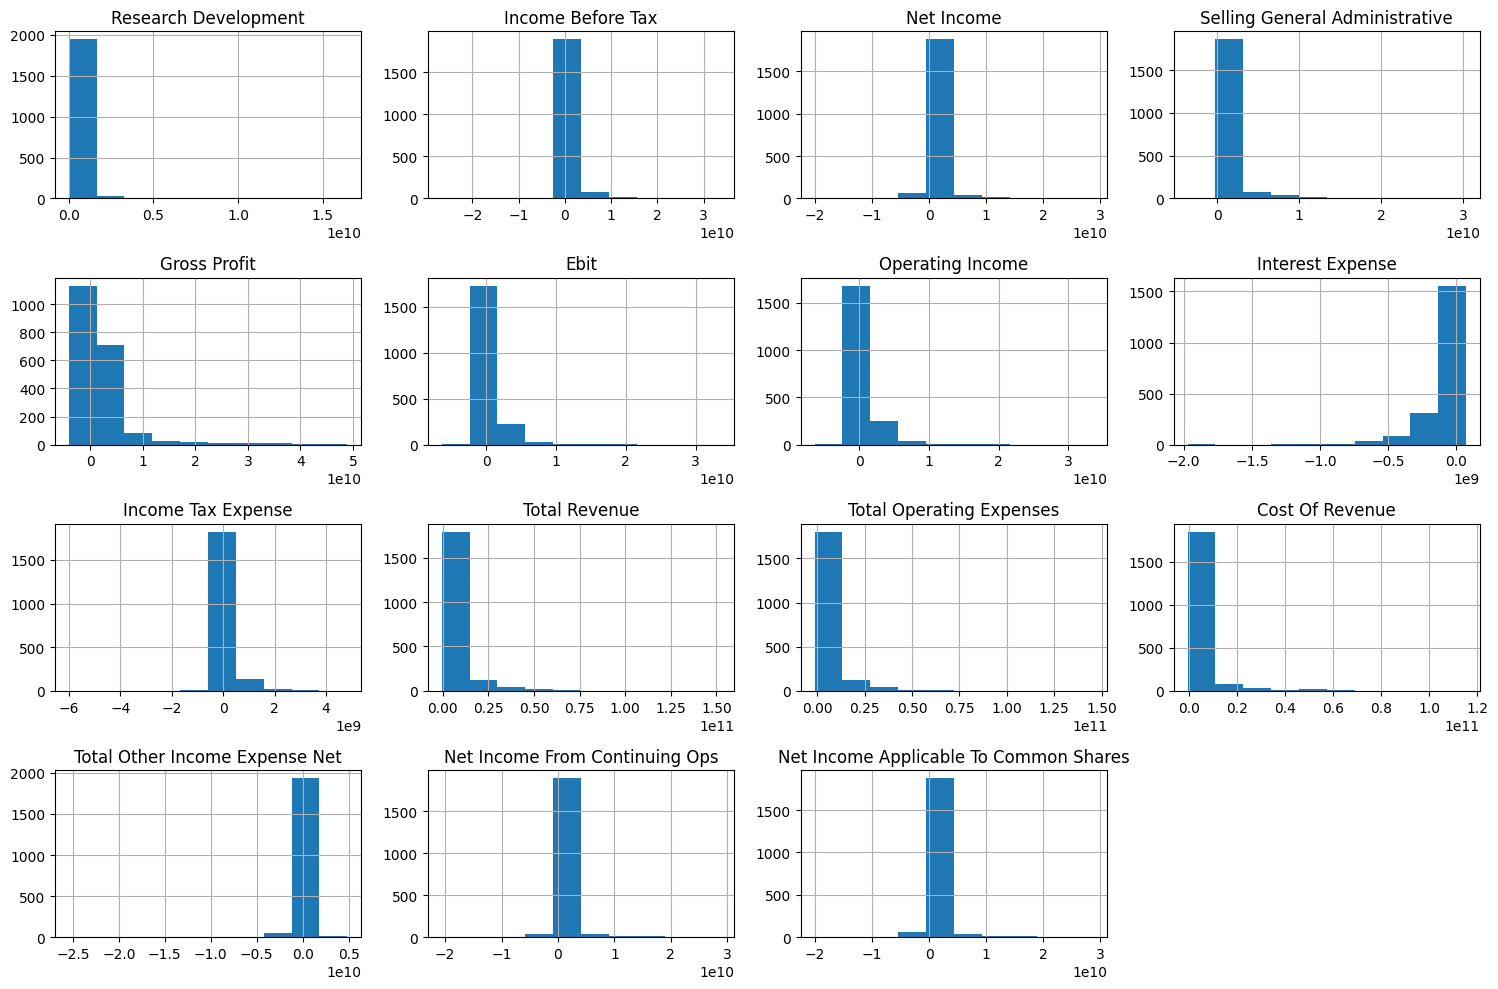

In [9]:
#plot histogram for visualization of data spread
financial_KPIs.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

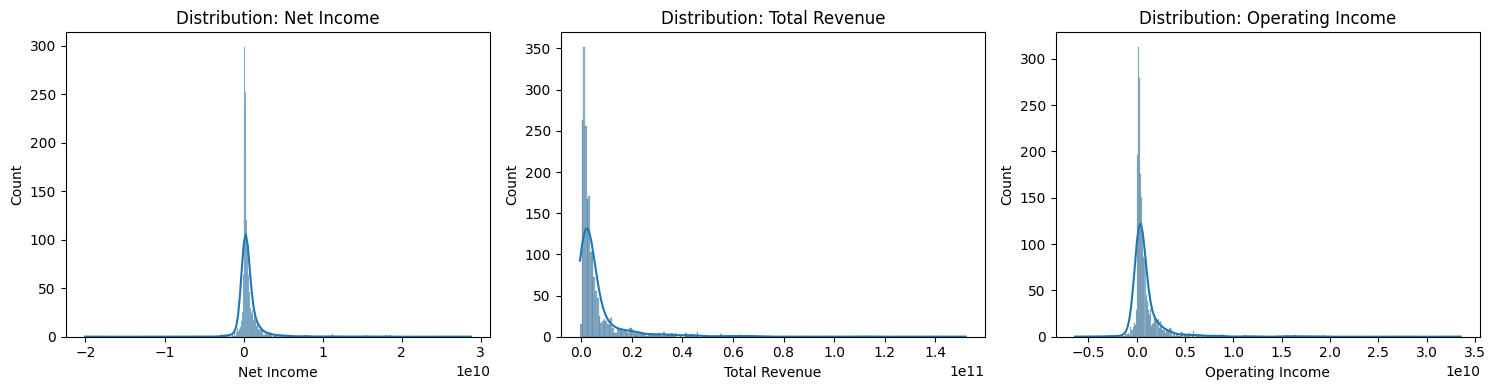

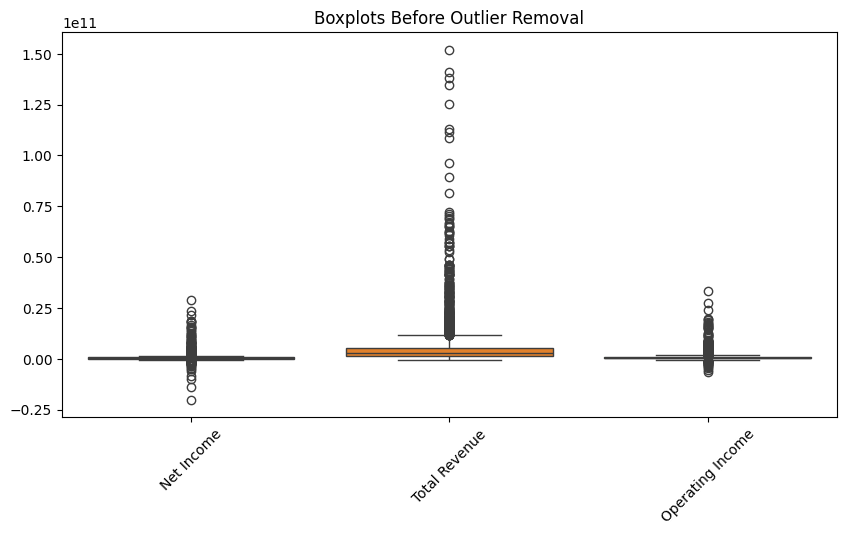

In [10]:
#INITIAL EDA (Before Outlier Treatment)
plt.figure(figsize=(15, 4))
for i, col in enumerate(['Net Income', 'Total Revenue', 'Operating Income']):
    plt.subplot(1, 3, i+1)
    sns.histplot(financial_KPIs[col].dropna(), kde=True)
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()

# Boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=financial_KPIs[['Net Income', 'Total Revenue', 'Operating Income']])
plt.title("Boxplots Before Outlier Removal")
plt.xticks(rotation=45)
plt.show()

The values in net income should be limit between the standard deviation for stable modelling outputs using interquartile limits.

In [11]:
#OUTLIER REMOVAL USING IQR METHOD
def remove_outliers_iqr(dataframe, cols):
    for col in cols:
        Q1 = dataframe[col].quantile(0.42)
        Q3 = dataframe[col].quantile(0.65)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        dataframe = dataframe[(dataframe[col] >= lower) & (dataframe[col] <= upper)]
    return dataframe

financial_KPIs = remove_outliers_iqr(financial_KPIs, ['Net Income', 'Total Revenue', 'Operating Income'])


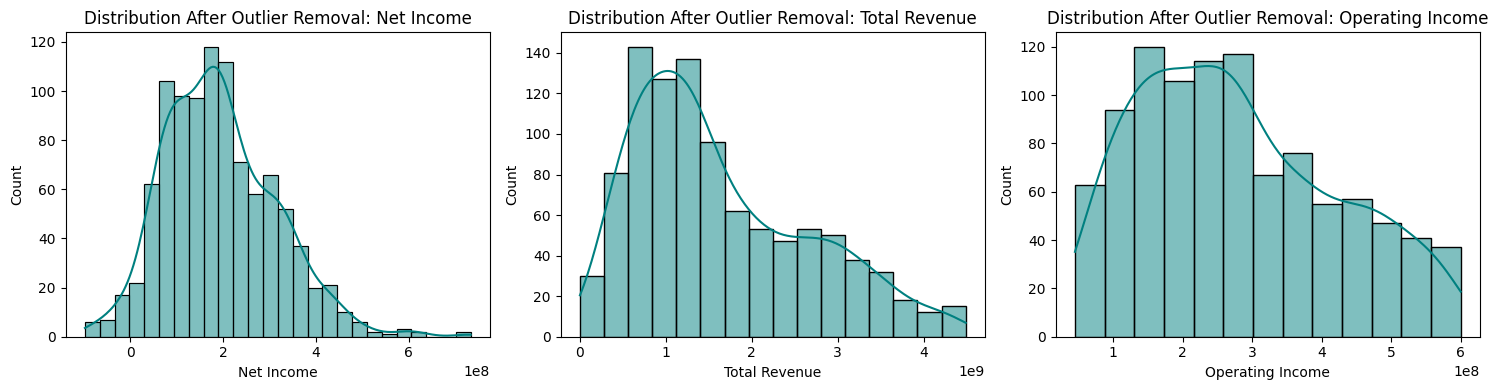

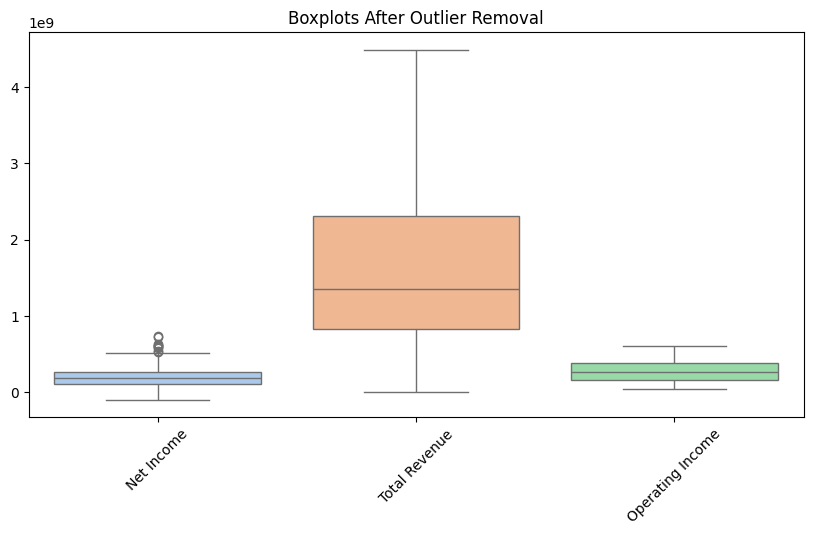

In [12]:
# EDA AFTER OUTLIER REMOVAL
plt.figure(figsize=(15, 4))
for i, col in enumerate(['Net Income', 'Total Revenue', 'Operating Income']):
    plt.subplot(1, 3, i+1)
    sns.histplot(financial_KPIs[col].dropna(), kde=True, color='teal')
    plt.title(f'Distribution After Outlier Removal: {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=financial_KPIs[['Net Income', 'Total Revenue', 'Operating Income']], palette="pastel")
plt.title("Boxplots After Outlier Removal")
plt.xticks(rotation=45)
plt.show()

Net income still has outliers but to avoid overfitting, as values are already fitted between 0.35 to 0.62.

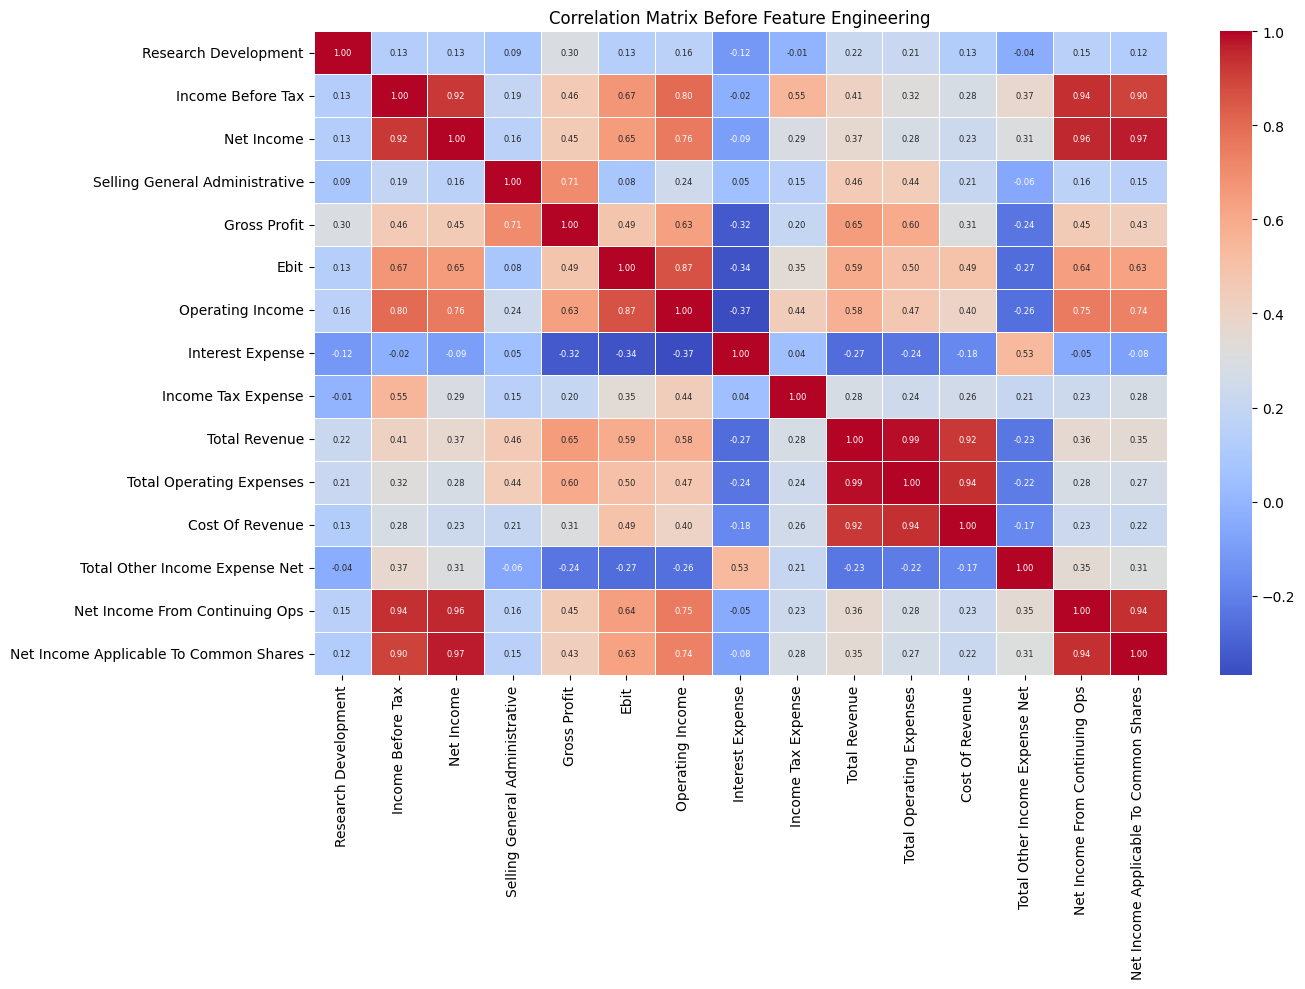

/tmp/ipython-input-14-719545562.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')


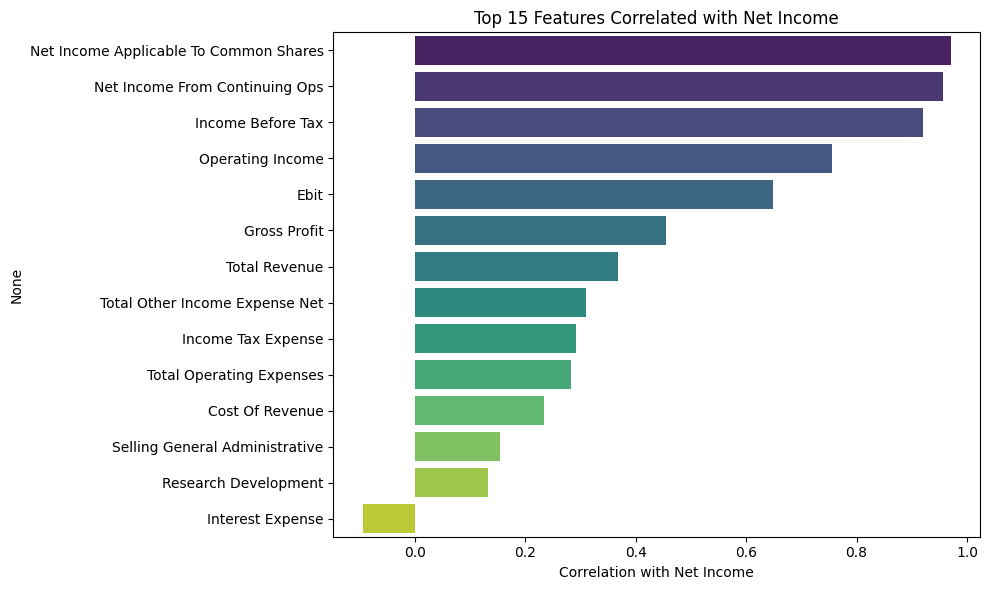

In [14]:
# Calculate the correlation matrix
correlation_matrix = financial_KPIs.select_dtypes(include=np.number).corr()

# Heatmap with readable annotations
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, annot_kws={"size": 6})
plt.title("Correlation Matrix Before Feature Engineering")
plt.tight_layout()
plt.show()

# Top 15 features most correlated with Net Income
top_corr = correlation_matrix['Net Income'].drop('Net Income').sort_values(ascending=False).head(15)

# Plot Top 15 Correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title("Top 15 Features Correlated with Net Income")
plt.xlabel("Correlation with Net Income")
plt.tight_layout()
plt.show()

Variables to eliminate:
Net income applicable to common shares , net income from continuing ops and income before tax are highly correleated.
Interest expense has negative correlation and decrease the predictive accuracy.

#Feature Engineering, Spliting Data & Model Initiating.

In [15]:
#PREPARE FEATURES & TARGET
X = financial_KPIs.drop(columns=['Net Income','Net Income Applicable To Common Shares','Net Income From Continuing Ops','Interest Expense','Income Before Tax'])
y = financial_KPIs['Net Income']

In [16]:
#SCALE & SPLIT
# Drop non-numeric columns before scaling
X_numeric = X.select_dtypes(include=np.number)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

Split of 70% training & 30% testing is implied. Standard scaler scale the high vaules near to zero taking mean.

In [17]:
#DEFINE MODELS
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    }

Selected white box models to evaulate. Alpha values indicate regularization parameter: L1 for lasso & L2 for ridge regression.

# Model Evaluation & Explaination


📊 Training and explaining: Linear Regression


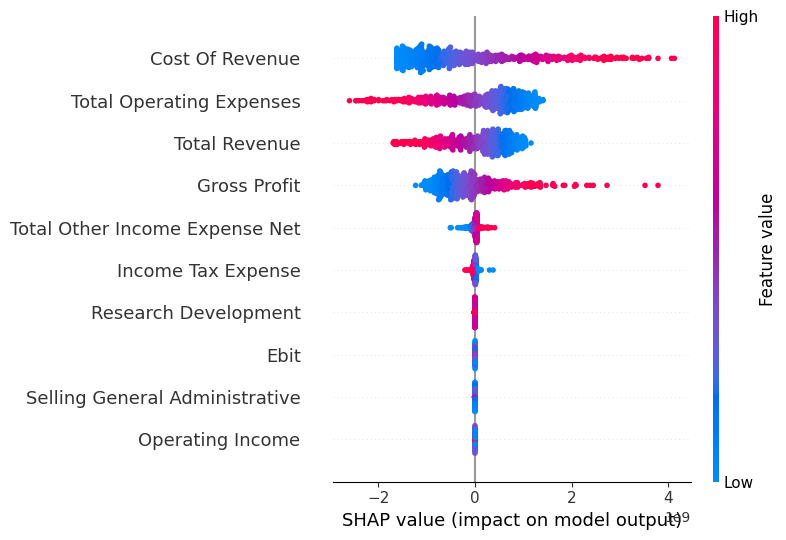

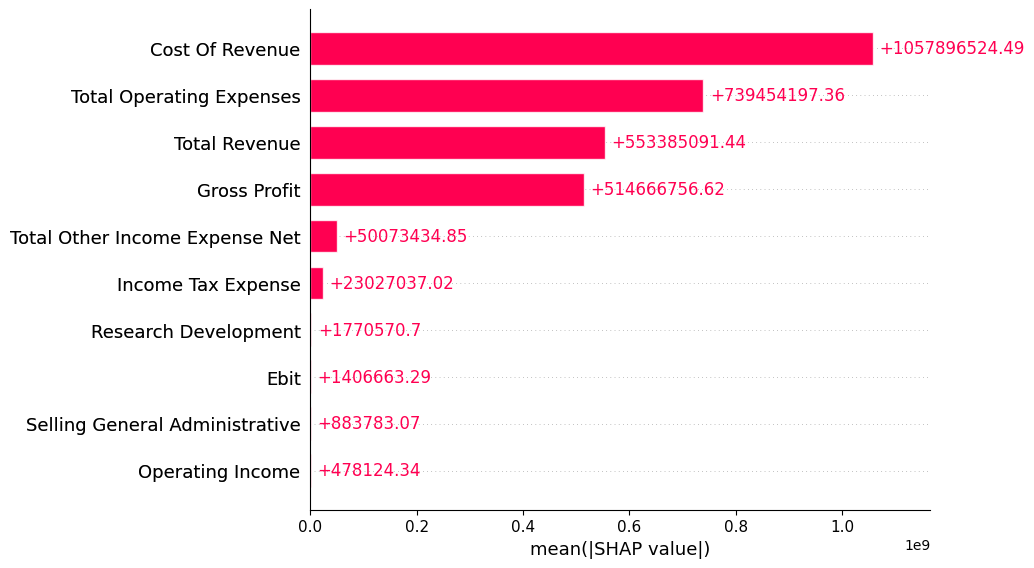


📈 Model Comparison Results:



,Model,R²,MAE,RMSE
0,Linear Regression,0.902071,1.422822e+07,3.667882e+07



📊 Training and explaining: Ridge Regression


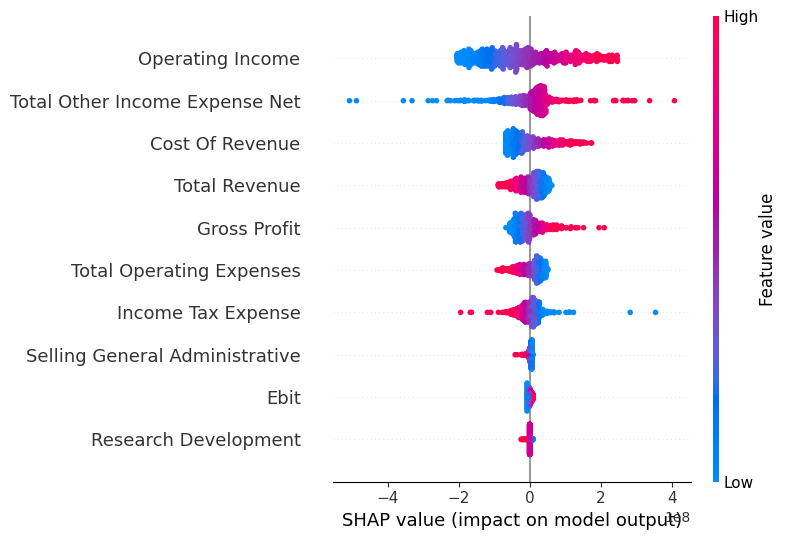

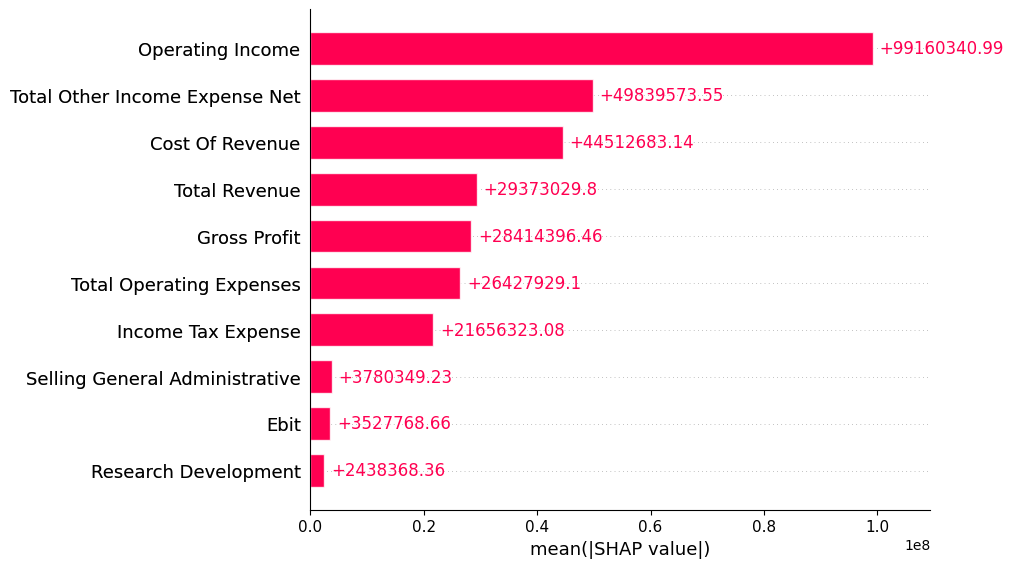


📈 Model Comparison Results:



,Model,R²,MAE,RMSE
0,Linear Regression,0.902071,1.422822e+07,3.667882e+07
1,Ridge Regression,0.869165,1.699837e+07,4.239577e+07



📊 Training and explaining: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.699e+17, tolerance: 1.037e+15
  model = cd_fast.enet_coordinate_descent(


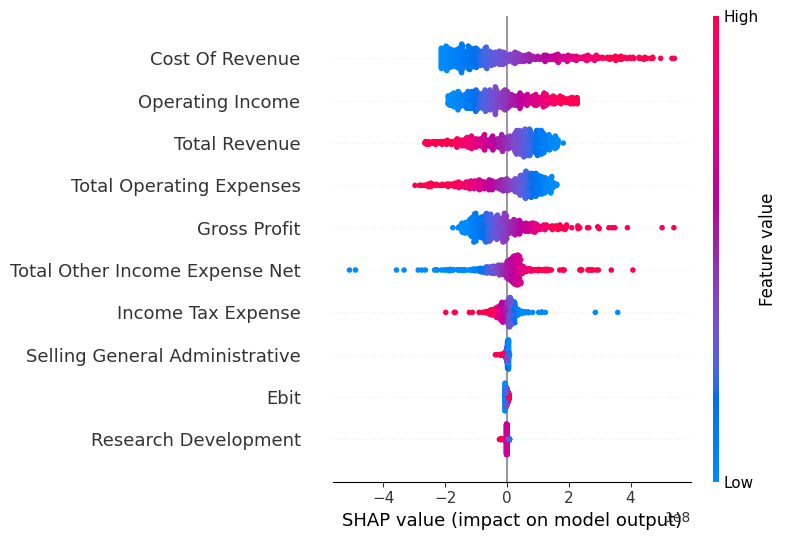

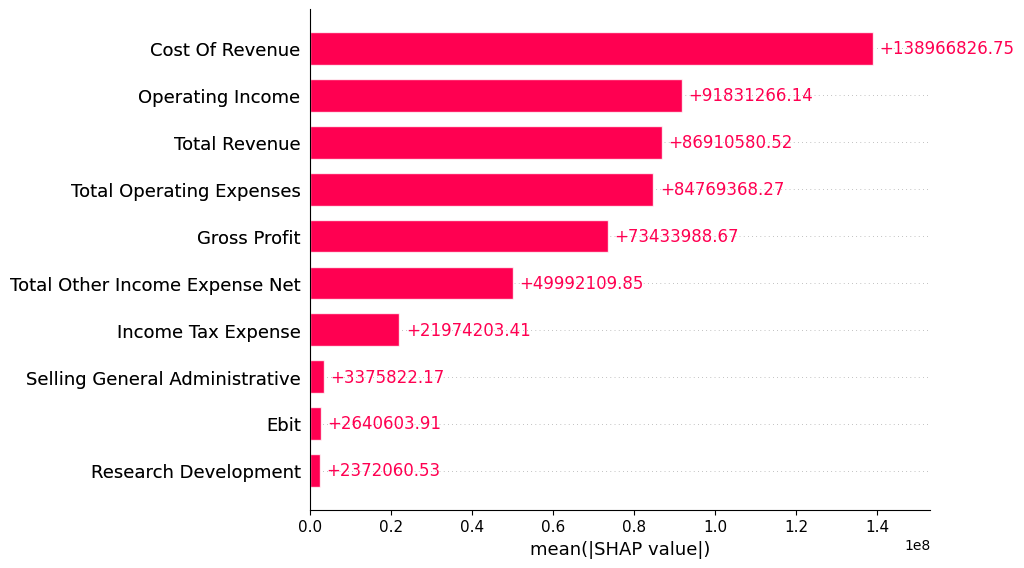


📈 Model Comparison Results:



,Model,R²,MAE,RMSE
0,Linear Regression,0.902071,1.422822e+07,3.667882e+07
2,Lasso Regression,0.874417,1.649845e+07,4.153620e+07
1,Ridge Regression,0.869165,1.699837e+07,4.239577e+07


In [18]:
results = []
shap_outputs = {} # Dictionary to store SHAP outputs

# Loop through each model
for name, model in models.items():
    print(f"\n📊 Training and explaining: {name}")

    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store evaluation results
    results.append({
        "Model": name,
        "R²": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    })

    # Create SHAP explainer with feature names
    # Ensure X_train is a DataFrame with correct column names
    X_train_df = pd.DataFrame(X_train, columns=X_numeric.columns)
    explainer = shap.Explainer(model, X_train_df)
    shap_values = explainer(X_train_df)

    # Store SHAP outputs
    shap_outputs[name] = (shap_values, X_train_df)

    # Plot SHAP summary and bar chart
    shap.summary_plot(shap_values, X_train_df)
    shap.plots.bar(shap_values, max_display=10)


    # Results DataFrame
    results_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
    print("\n📈 Model Comparison Results:\n")
    display(results_df)

Linear Regression: Achieved the highest predictive accuracy (R² = 0.90) with clearly interpretable SHAP values, making it the most reliable model for both performance and transparent financial insight.
Lasso Regression: Delivered a good balance between accuracy and model simplicity by selecting only the most relevant financial features, making it ideal for interpretable, sparse modeling.
Ridge Regression: Maintained solid accuracy while distributing importance across all features, offering stability and robustness in scenarios where all financial indicators are deemed valuable.

#Repeating modelling for polynomial regression


📊 Evaluation for Polynomial Regression (degree=2)
R²: 0.8982
MAE: 13588266.6742
RMSE: 37390041.8683

📊 SHAP for Polynomial Regression (degree=2)


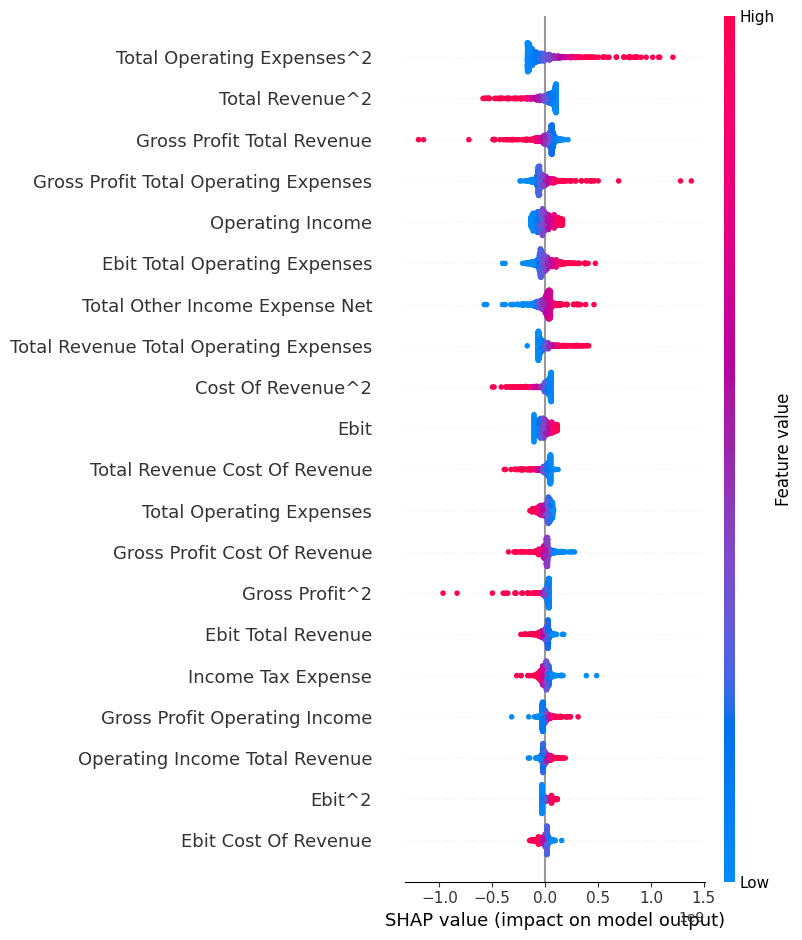

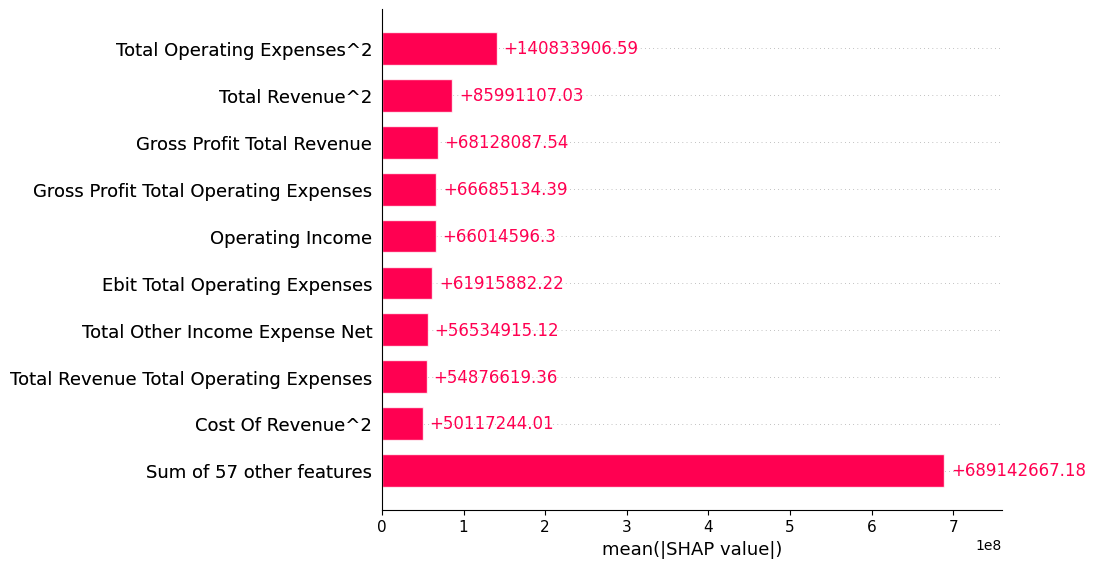

In [19]:
# Create and fit the polynomial regression pipeline
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)

# Predict on test set
y_pred_poly = poly_model.predict(X_test)

# Evaluate performance
r2_poly = r2_score(y_test, y_pred_poly)
mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print("\n📊 Evaluation for Polynomial Regression (degree=2)")
print(f"R²: {r2_poly:.4f}")
print(f"MAE: {mae_poly:.4f}")
print(f"RMSE: {rmse_poly:.4f}")

# Extract internal steps
poly_features = poly_model.named_steps['polynomialfeatures']
linear_model = poly_model.named_steps['linearregression']

# Transform X_train to include polynomial terms
X_poly = poly_features.transform(X_train)

# Get feature names after transformation using the numeric column names
poly_feature_names = poly_features.get_feature_names_out(input_features=X_numeric.columns)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)

# SHAP analysis on polynomial model
explainer_poly = shap.Explainer(linear_model, X_poly_df)
shap_values_poly = explainer_poly(X_poly_df)

# Plot SHAP summary and bar
print("\n📊 SHAP for Polynomial Regression (degree=2)")
shap.summary_plot(shap_values_poly, X_poly_df)
shap.plots.bar(shap_values_poly, max_display=10)



Polynomial Regression balances performance and feature interaction transparency, making it valuable for understanding compound financial dynamics behind Net Income.